In [1]:
%run ./import_ap.ipynb

In [2]:
import apple_pie as ap
import brutils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
exp = ap.make_cur_exper()

reading in wells : 0.63 seconds
all exper init : 1.22 seconds


In [4]:
c = brutils.one_value(exp.condits)
cdf = pd.DataFrame(c.dists)
cdf = cdf.sort_index(axis=1)

In [7]:
cdf.loc[:,('B02','cell 1'):('B02','cell 4')][:5]

B02                                                             \
     cell 1   cell 11    cell 14    cell 2 cell 222 cell 284    cell 3   
0  4.084059  3.815504  17.243134  2.649476      NaN      NaN  2.256764   
1  2.679080  1.517957   2.459129  2.950986      NaN      NaN  2.537259   
2  0.269232  1.724615   1.255760  7.872467      NaN      NaN  3.202726   
3  1.746710  4.989260   3.325596  5.409114      NaN      NaN  6.365154   
4  3.301719  1.621234  15.840531  4.230010      NaN      NaN  7.662083   

                      
  cell 354    cell 4  
0      NaN  2.895548  
1      NaN  5.997996  
2      NaN  3.487701  
3      NaN  1.424251  
4      NaN  0.726184

In [8]:
cdf_stats = cdf.apply(pd.DataFrame.describe, axis=1)

In [9]:
cdf_stats[:5]

,count,mean,std,min,25%,50%,75%,max
0,25.0,4.275085,3.086365,1.159733,2.512596,3.886923,4.620247,17.243134
1,23.0,3.973720,5.233676,0.393014,2.223519,2.820952,3.648817,27.359509
2,23.0,4.738842,6.245864,0.269232,1.710192,3.487701,4.777745,31.703374
3,24.0,4.728013,6.129991,0.066980,1.461427,2.612880,5.288656,26.161156
4,24.0,5.210653,5.028987,0.467440,2.121746,3.420257,7.218819,21.848929


(0, 20)

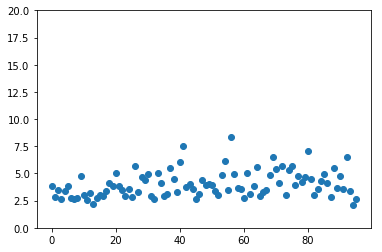

In [10]:
plt.scatter(x=cdf_stats.index,y=cdf_stats['50%'])
ax = plt.gca()
ax.set_ylim(0,20)

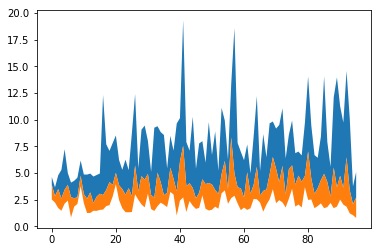

In [11]:
plt.fill_between(cdf_stats.index,cdf_stats['50%'],cdf_stats['75%'])
plt.fill_between(cdf_stats.index,cdf_stats['25%'],cdf_stats['50%'])

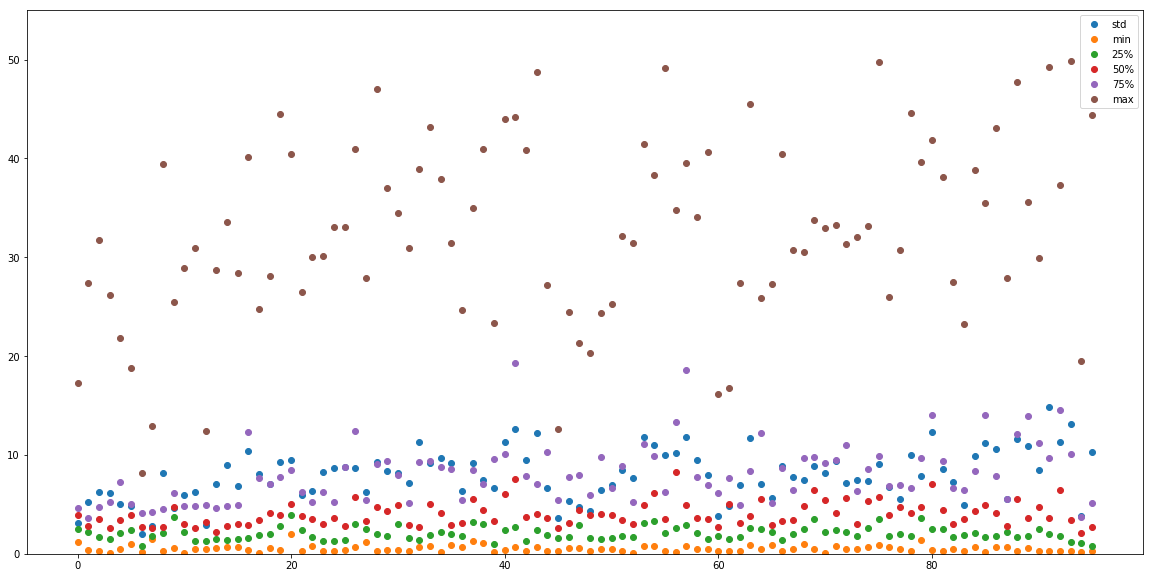

In [12]:
plt.figure(figsize=(20,10))
for col in cdf_stats.columns[2:] :
    plt.plot(list(range(96)),cdf_stats[col],marker='o',label=col,linewidth=0)

ax = plt.gca()
ax.set_ylim(0,55)
plt.legend()
plt.show()


**get_natural_cubic_spline_model code hidden bellow**

In [13]:
# https://stackoverflow.com/a/51359826

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

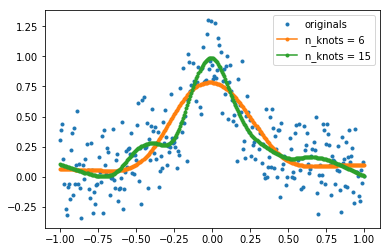

In [19]:

# make example data
x = np.linspace(-1,1,300)
y = func(x) + np.random.normal(0, 0.2, len(x))

# The number of knots can be used to control the amount of smoothness
model_6 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=6)
model_15 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=15)
y_est_6 = model_6.predict(x)
y_est_15 = model_15.predict(x)


plt.plot(x, y, ls='', marker='.', label='originals')
plt.plot(x, y_est_6, marker='.', label='n_knots = 6')
plt.plot(x, y_est_15, marker='.', label='n_knots = 15')
plt.legend(); plt.show()

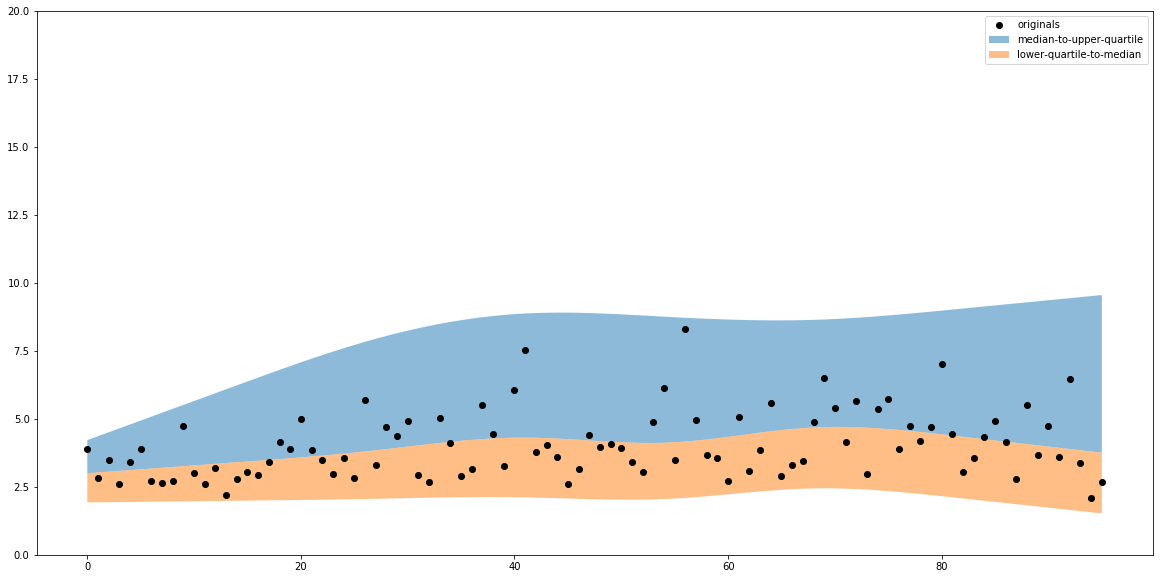

In [20]:
def func(x):
    return 1/(1+25*x**2)

# make example data
plt.figure(figsize=(20,10))

x = np.array(list(range(96)))

y50 = cdf_stats['50%']

y75 = cdf_stats['75%']
y25 = cdf_stats['25%']
# The number of knots can be used to control the amount of smoothness
model_6 = get_natural_cubic_spline_model(x, y50, minval=min(x), maxval=max(x), n_knots=6)
model_15 = get_natural_cubic_spline_model(x, y50, minval=min(x), maxval=max(x), n_knots=15)
y_est_6 = model_6.predict(x)
y_est_15 = model_15.predict(x)

model75  = get_natural_cubic_spline_model(x, y75, minval=min(x), maxval=max(x), n_knots=6)
y_est75 = model75.predict(x)

model25  = get_natural_cubic_spline_model(x, y25, minval=min(x), maxval=max(x), n_knots=6)

y_est25 = model25.predict(x)


plt.fill_between(x, y_est_6, y_est75, label='median-to-upper-quartile',alpha=.5)
plt.fill_between(x, y_est25, y_est_6, label='lower-quartile-to-median',alpha=.5)
# plt.fill_between(cdf_stats.index,cdf_stats['25%'],cdf_stats['50%'])

plt.plot(x, y50, ls='', marker='o', label='originals', color='black')
# plt.plot(x, y_est_6, label='n_knots = 6')
#plt.plot(x, y_est_15,  label='n_knots = 15')
ax = plt.gca()
ax.set_ylim(0,20)
plt.legend(); plt.show()

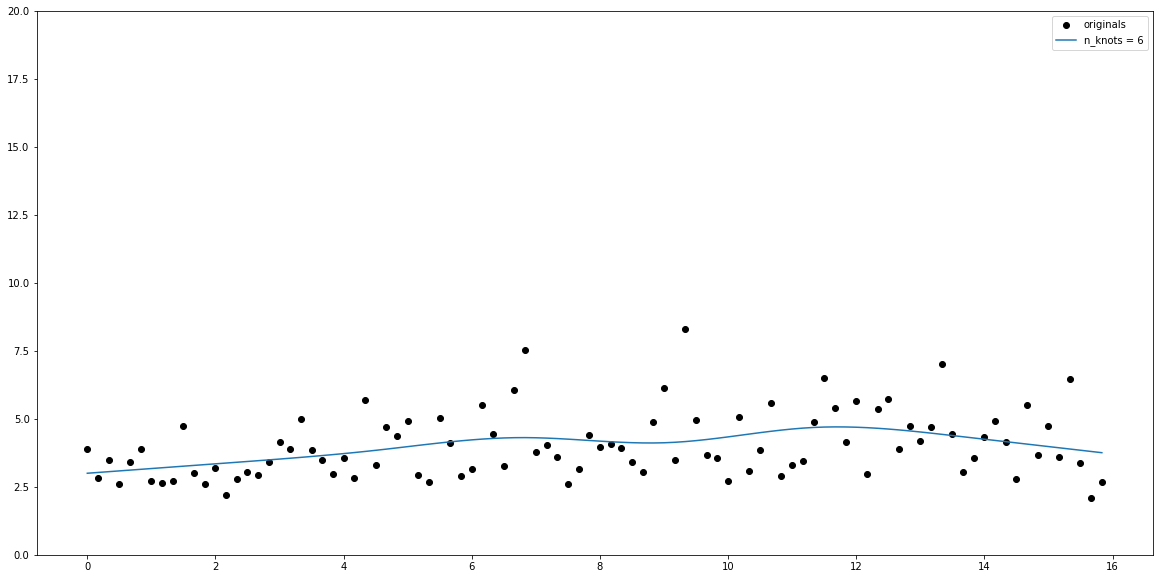

In [21]:

# make example data
plt.figure(figsize=(20,10))

y50 = cdf_stats['50%']

time = np.array([n/6 for n in range(len(y50))])
x = time


y75 = cdf_stats['75%']
y25 = cdf_stats['25%']
# The number of knots can be used to control the amount of smoothness
model_6 = get_natural_cubic_spline_model(x, y50, minval=min(x), maxval=max(x), n_knots=6)
model_15 = get_natural_cubic_spline_model(x, y50, minval=min(x), maxval=max(x), n_knots=15)
y_est_6 = model_6.predict(x)
y_est_15 = model_15.predict(x)

model75  = get_natural_cubic_spline_model(x, y75, minval=min(x), maxval=max(x), n_knots=6)
y_est75 = model75.predict(x)

model25  = get_natural_cubic_spline_model(x, y25, minval=min(x), maxval=max(x), n_knots=6)

y_est25 = model25.predict(x)


# plt.fill_between(x, y_est_6, y_est75, label='median-to-upper-quartile')
# plt.fill_between(x, y_est25, y_est_6, label='lower-quartile-to-median')
# # plt.fill_between(cdf_stats.index,cdf_stats['25%'],cdf_stats['50%'])

plt.plot(x, y50, ls='', marker='o', label='originals', color='black')
plt.plot(x, y_est_6, label='n_knots = 6')
#plt.plot(x, y_est_15,  label='n_knots = 15')
ax = plt.gca()
ax.set_ylim(0,20)
plt.legend(); plt.show()

array([3.00042196, 3.02929297, 3.05816398, 3.08703499, 3.11590601,
       3.14477702, 3.17364803, 3.20251904, 3.23139006, 3.26026107,
       3.28913208, 3.31800309, 3.34687411, 3.37574512, 3.40461821,
       3.43356403, 3.46273592, 3.49229209, 3.5223908 , 3.55319027,
       3.58484876, 3.61752449, 3.65137571, 3.68656065, 3.72323755,
       3.76156465, 3.8017002 , 3.84380242, 3.88793089, 3.93353636,
       3.9798375 , 4.02605255, 4.07139977, 4.11509738, 4.15636362,
       4.19441674, 4.22847496, 4.25775654, 4.28147971, 4.2988627 ,
       4.30912376, 4.31148962, 4.30592744, 4.29370887, 4.27623834,
       4.25492028, 4.23115913, 4.20635933, 4.1819253 , 4.15926149,
       4.13977233, 4.12486226, 4.1159357 , 4.1143971 , 4.12165088,
       4.13892519, 4.16571615, 4.20053682, 4.24188899, 4.28827444,
       4.33819494, 4.39015229, 4.44264826, 4.49418464, 4.5432632 ,
       4.58838573, 4.62805401, 4.66076981, 4.68503601, 4.69990233,
       4.70585356, 4.703607  , 4.69387995, 4.67738973, 4.65485

Pipeline(memory=None,
     steps=[('nat_cubic', NaturalCubicSpline(knots=array([ 2.2619 ,  4.52381,  6.78571,  9.04762, 11.30952, 13.57143]),
          max=None, min=None, n_knots=6, n_params=5)), ('regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

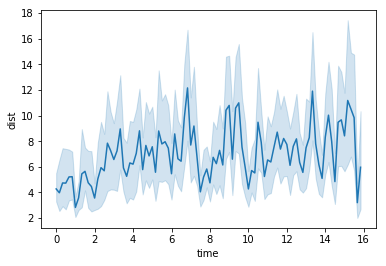

In [18]:
import seaborn as sns


x=[]
y=[]
time = [x/6 for x in range(len(cdf))]
for col in cdf.columns :
    for i in range(len(cdf[col])) :
        x.append(time[i])
        y.append(cdf[col][i])
        
cdf_butts = pd.DataFrame({'time':x,'dist':y})
sns.lineplot(x='time', y='dist',data=cdf_butts)